## Workflow authros by Tristan Salles and Beatriz Hadler Boggiani

In [1]:
import os
import math
import numpy as np
import pandas as pd
import pygmt
import imageio
import xarray as xr
import numpy as np
from scipy.interpolate import interp1d
import pygplates

import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)

### This workflow assists with plotting the results from the Landscape Evolution Model produced in Salles et al, 2023:

Statistical analyses using these datasets are also available towards the end of this workflow. 

The necessary files to run this code are:
- csv file with existing Porphyry Copper deposits (available from Yanites & Kesler, 2015 - https://doi.org/10.1038/ngeo2429)
- rot - rotation and geometry files (https://www.earthbyte.org/paleodem-resource-scotese-and-wright-2018)
- NetCDF outputs from the simulation (https://osf.io/5aek4/)

Read the dataset from the supplementary material

In [2]:
data_df = pd.read_excel('data/41561_2015_BFngeo2429_MOESM588_ESM.xlsx')
data_df.head()

,Deposit number,Lat.,Long.,Age (Ma),Erosion rate (km/My),Ind. depth e-rate (km/My),Modern MAP (mm),Slope (o) (90m),Slope (o) (10km),Frequency
0,1,-27.371,-66.280,5.5,0.36364,0.36364,221.12,30.852928,28.039921,4
1,2,-30.500,-69.750,12.0,0.16667,0.00000,145.96,15.043551,19.502411,6
2,3,-27.267,-66.650,8.5,0.23529,0.00000,221.12,10.777455,9.288019,4
3,4,-27.330,-66.609,7.5,0.26667,0.33707,221.12,5.750363,13.384438,4
4,5,-27.400,-66.550,7.0,0.28571,0.00000,221.12,17.312500,19.761951,4


In [3]:
lon = data_df['Long.'].values
lat = data_df['Lat.'].values
erorate = data_df['Erosion rate (km/My) '].values
ages = data_df['Age (Ma)'].values
freq = data_df['Frequency'].values

In [4]:
bins = [0,1.5,3,6,9,12,15,20,25,30,35,55,65]
labels = []
for x in range(1, len(bins)):
    labels.append('{}-{}'.format(bins[x-1],bins[x]))
binned = pd.cut(data_df['Age (Ma)'], bins=bins, labels=labels)
data_df['Ages Cat'] = binned
data_df['Ages Cat'] = data_df['Ages Cat'].astype(dtype="category")
labels = list(data_df['Ages Cat'].cat.categories)

Take the data for a specific region

In [5]:
filter1 = data_df[(data_df['Long.'] > -180) & (data_df['Long.'] < 180) ]
filter2 = filter1[(filter1['Lat.'] > -90) & (filter1['Lat.'] < 90) ]

Plot it

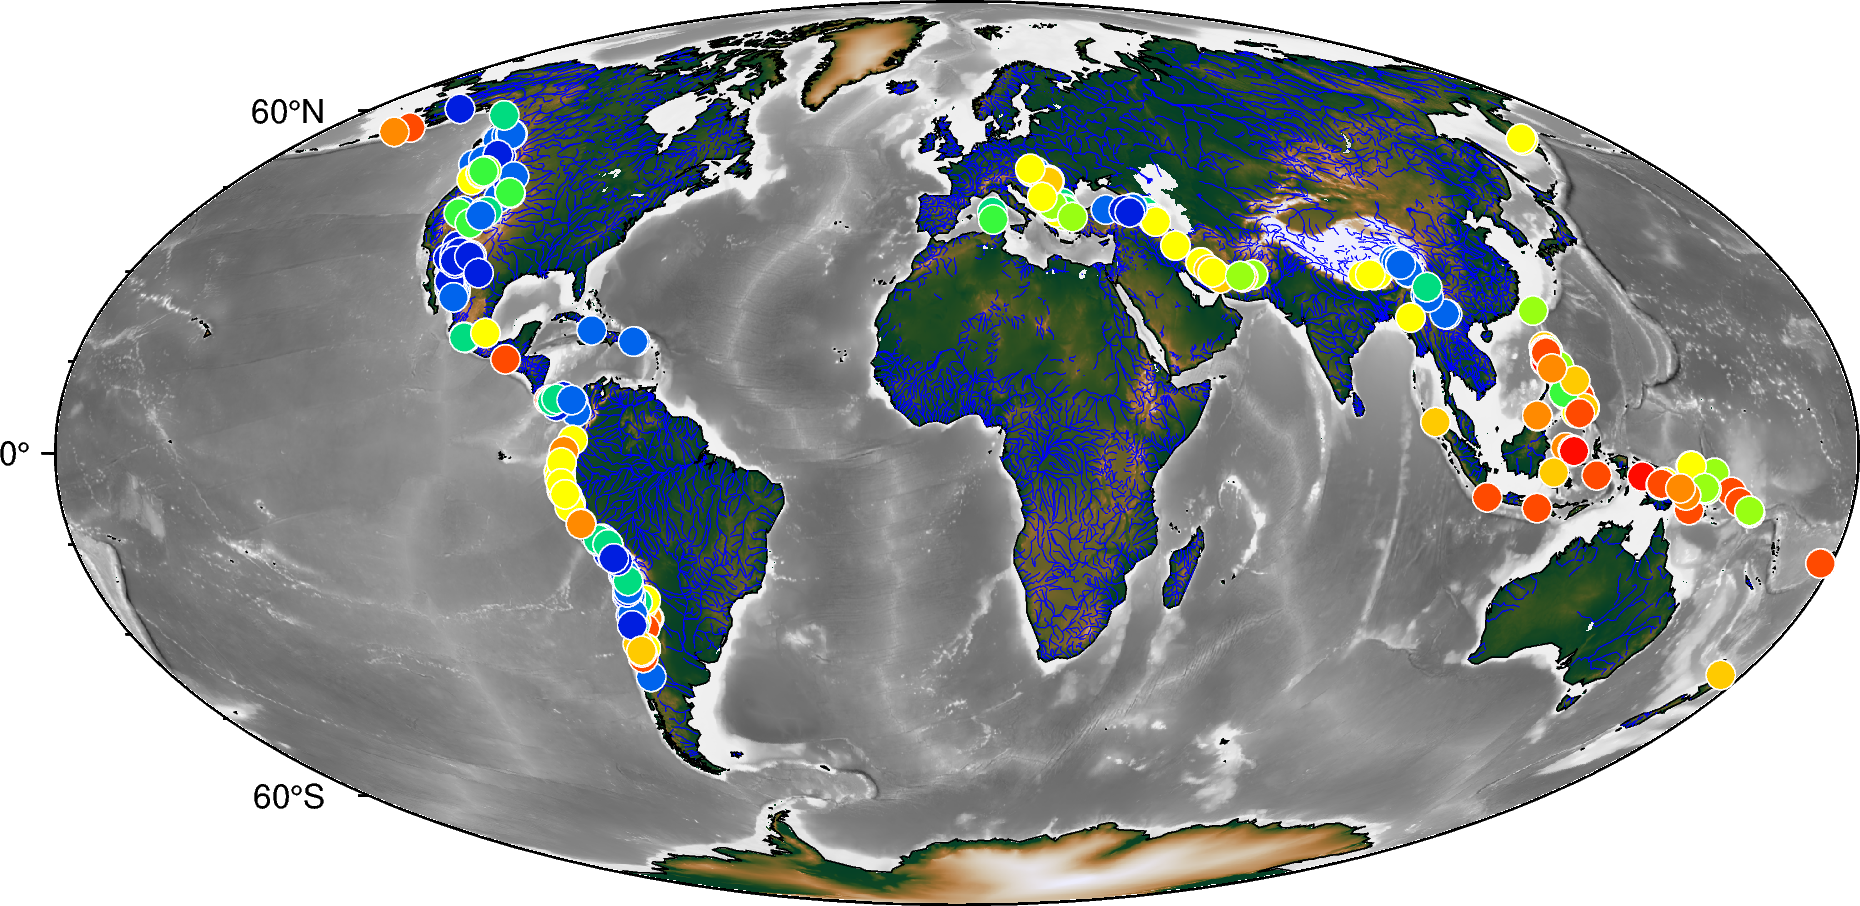

In [6]:
grid = pygmt.datasets.load_earth_relief('10m', registration="gridline")
region = [-180,-180,-90,90]

fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black'):
    pygmt.makecpt(cmap="fes", series=[-10000, 4000])
    fig.basemap(region='d', projection='W6i', frame='afg')
    fig.grdimage(grid=grid)
    fig.coast(shorelines=["1/0.25p,black"], 
              rivers="a/0.1p,blue")
    # fig.colorbar(position="jBC+o0c/-2.5c+w7c/0.3c+h",frame=["a5000", "x+lElevation (m)"])

with pygmt.config(FONT='8p,Helvetica,black'):
    pygmt.makecpt(
        cmap="seis",
        series=(data_df['Ages Cat'].cat.codes.min(), data_df['Ages Cat'].cat.codes.max(), 1),
        color_model="+c" + ",".join(labels),
    )
    fig.plot(
        x=filter2['Long.'],
        y=filter2['Lat.'],
        style="c0.25c",
        cmap=True,
        color=filter2['Ages Cat'].cat.codes.astype(int),
        no_clip=True,
        pen="white",
        
    )
#     fig.colorbar(position='JMR+o0.5c/-0.5c+w6c/0.3c')
#     fig.text(text="Age (Myr)", position="TR", xshift="2.6c", yshift="-1.8c")

fig.show(width=800)

Reconstruct position through time

In [7]:
# Flat lat/lon array.
SAlat = filter2['Lat.'].values
SAlon = filter2['Long.'].values 

MovingPlate = 201
RelativePlate = 1
TimeStep = 5
times = np.arange(0,101,float(TimeStep))

rotation_filename = 'data/PALEOMAP_PlateModel.rot'

def getTrailPts(lat,lon):
    
    # Create the motion path feature
    digitisation_time = 0
    seed_points_at_digitisation_time = pygplates.MultiPointOnSphere([(lat, lon)])
    motion_path_feature = pygplates.Feature.create_motion_path(
            seed_points_at_digitisation_time,
            times,
            valid_time=(200., 0.),
            relative_plate=RelativePlate,
            reconstruction_plate_id = MovingPlate)

    rotation_model = pygplates.RotationModel(rotation_filename)

    # Create the shape of the motion path
    reconstruction_time = 0
    reconstructed_motion_paths = []
    pygplates.reconstruct(
            motion_path_feature, rotation_model, reconstructed_motion_paths, reconstruction_time,
            reconstruct_type=pygplates.ReconstructType.motion_path)

    for reconstructed_motion_path in reconstructed_motion_paths:
        trail = reconstructed_motion_path.get_motion_path().to_lat_lon_array()
    
    x, y = np.flipud(trail[:,1]), np.flipud(trail[:,0])
    
    return np.flipud(trail[:,1]), np.flipud(trail[:,0])


allTrail = []
for k in range(len(SAlat)):
    lonlatTime = getTrailPts(SAlat[k], SAlon[k])
    allTrail.append(lonlatTime)

Read the global model dataset

In [8]:
step = 0

out = 'model2_VAldes//'
dataset = xr.open_dataset(out+'physio'+str(step)+'Ma.nc')

Plot the model output

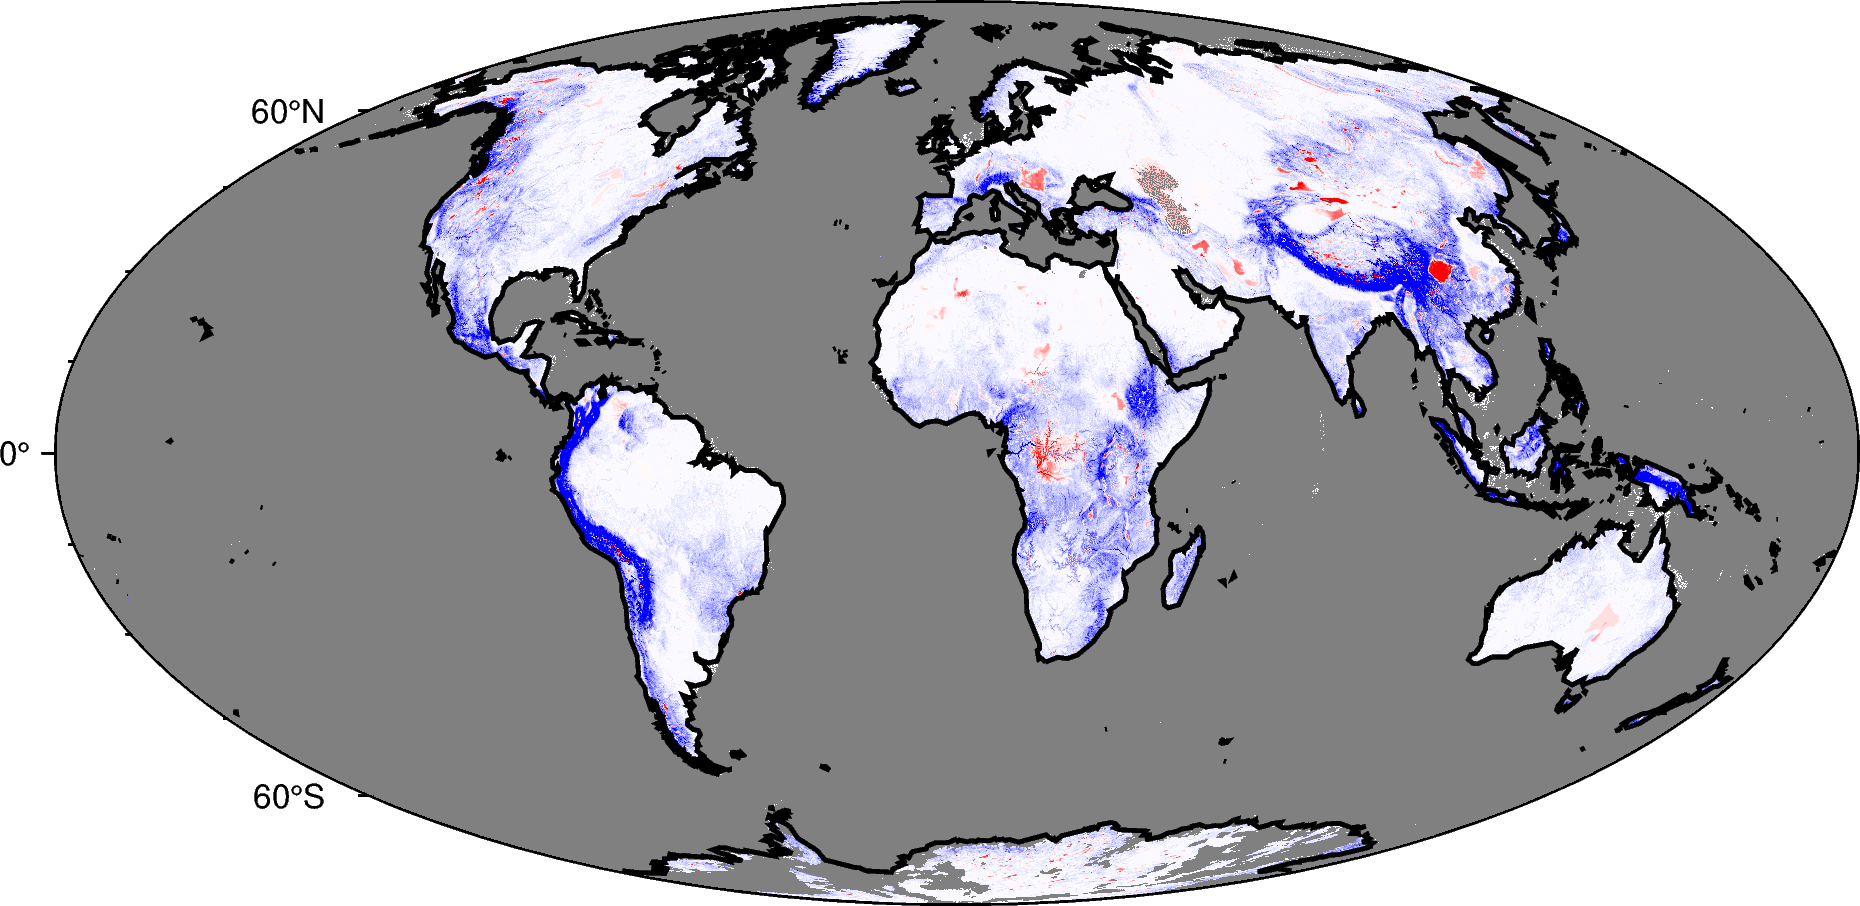

In [9]:
fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black',COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    fig.basemap(region='d', projection='W6i', frame='afg')
    # Ero/dep
    pygmt.makecpt(cmap="polar",series=[-0.2,0.2, 0.01])
    fig.grdimage(dataset.erorate, 
                 shading=False, 
                 frame=False)
    fig.coast(shorelines=["1/1p,black"], 
#               rivers="a/0.1p,darkblue"
             )
    # fig.colorbar(position="jBC+o0c/-1.5c+w7c/0.3c+h",frame=["a0.1", "x+lErosion/Deposition (mm/yr)"])
fig.show(width=800)

Extract model information for the deposit positions

In [10]:
dataset

<xarray.Dataset>
Dimensions:    (latitude: 3601, longitude: 7201)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.95 -89.9 -89.85 ... 89.9 89.95 90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables: (12/15)
    zsim       (latitude, longitude) float64 ...
    erorate    (latitude, longitude) float64 ...
    rain       (latitude, longitude) float64 ...
    wfflux     (latitude, longitude) float64 ...
    sflux      (latitude, longitude) float64 ...
    basin      (latitude, longitude) float64 ...
    ...         ...
    tcor       (latitude, longitude) float64 ...
    slpcat     (latitude, longitude) float64 ...
    surfcat    (latitude, longitude) float64 ...
    hydrocat   (latitude, longitude) float64 ...
    phydiv     (latitude, longitude) float64 ...
    wflux      (latitude, longitude) float64 ...
Attributes:
    title:          0Ma Physiographic Dataset
    summary:        Parameters calculated using goSPL (the Global Scalable Pa...
    project:        Paleo-physiography reconstruction
    institution:    Faculty of Science | School of Geosciences | The Universi...
    creator_url:    http://earthcolab.org
    creator_name:   Tristan Salles
    creator_email:  tristan.salles@sydney.edu.au
    license:        CC BY-NC-SA (Creative Common) - This license allows reuse...
    date_created:   Sat Oct  1 16:31:34 2022

In [11]:
def GetModelData(dataset,timestep):
    
    elevPts = []
    rainPts = []
    erodepPts = []
#     slpcatPts = []
    for pt in range(len(SAlat)):
        lonPt = allTrail[pt][0]
        latPt = allTrail[pt][1]
        ptdata = dataset.sel(latitude=latPt[timestep], longitude=lonPt[timestep], method='nearest')
        elevPts.append(ptdata.zsim.values.tolist())
        rainPts.append(ptdata.rain.values.tolist())
        erodepPts.append(ptdata.erorate.values.tolist())
#         slpcatPts.append(ptdata.slpcat.values.tolist())
        
    dataframe = pd.DataFrame(elevPts, columns=['elev'])
    dataframe['rain'] = rainPts
    dataframe['erorate'] = erodepPts
#     dataframe['slpcat'] = slpcatPts
    
    return dataframe

modelData = []
for k in range(len(times)-1):
    ncdata = xr.open_dataset(out+'physio'+str(int(times[k]))+'Ma.nc')
    modelData.append(GetModelData(ncdata,k))

Extract parameters for each deposit based on its age

In [12]:
def myround(x, base=5):
    return base * round(x/base)

def getDepositCharacteristics2(modelData,ages,depnb):
    
    age = ages[depnb]
    dt_site = np.arange(0,myround(age)+1,5).tolist()
    frac_site = np.ones(len(dt_site)).tolist()
    if dt_site[-1] < age:
        dt_site.append(age-dt_site[-1])
        frac_site.append(dt_site[-1]/5.)
        stime = dt_site.copy()
        stime[-1] = dt_site[-1]+dt_site[-2]
    else:
        stime = dt_site.copy()
        
        
#     siteTime = siteNb.isel(age=slice(0,len(dt_site)))
#     print(frac_site,stime,len(dt_site))
    depZ = []
    depRain = []
    depTime = []
    depExhum = []
    for s in range(len(dt_site)):
        depZ.append(modelData[s]['elev'][depnb]) 
        depRain.append(modelData[s]['rain'][depnb]) 
        depTime.append(stime[s])
        depExhum.append(-modelData[s]['erorate'][depnb]) 
    dep_df = pd.DataFrame(depZ, columns=['elev'])
    dep_df['exhrate'] = depExhum
    dep_df['rain'] = depRain
    dep_df['time'] = depTime
    
    exhRate = dep_df['exhrate'].values
    ids = np.where(exhRate>0)[0]
    exhRate = exhRate[ids]
    
    masked_data = np.ma.masked_array(exhRate, exhRate<0)
    dt = np.asarray(frac_site)[ids]
    average = np.ma.average(masked_data, weights=dt)
    emplacedepth = average*dt.sum()*5.
    meanero = np.average(dep_df['exhrate'].values, weights=frac_site)
    meanrain = np.average(dep_df['rain'].values, weights=frac_site)
    
    return dep_df, emplacedepth, average, meanrain

ages = filter2['Age (Ma)'].values
dep_df, emplacedepth, meanero, meanrain = getDepositCharacteristics2(modelData,ages,260)

In [13]:
meanero = []
meanrain = []
emplacedepth = []
depVars = []
ages = filter2['Age (Ma)'].values
for k in range(len(modelData[0])):
    tmp = getDepositCharacteristics2(modelData,ages,k)
    depVars.append(tmp[0])
    meanero.append(tmp[2])
    meanrain.append(tmp[3])
    emplacedepth.append(tmp[1])

In [14]:
depth = []
for k in range(len(depVars)):
    depth.append(-depVars[k].exhrate.values[0])
depth_df = pd.DataFrame()
depth_df['depth'] = emplacedepth.copy() #depth
depth_df['lat'] = SAlat

lbins = np.arange(-80,80,5).tolist()
llabels = []
for x in range(1, len(lbins)):
    if lbins[x]<=0:
        llabels.append('{} S - {} S'.format(-lbins[x-1],-lbins[x]))
    else:
        llabels.append('{} N - {} N'.format(lbins[x-1],lbins[x]))
lbinned = pd.cut(depth_df['lat'], bins=lbins, labels=llabels)
depth_df['Lat. Cat'] = lbinned
depth_df['Lat. Cat'] = depth_df['Lat. Cat'].astype(dtype="category")
llabels = list(depth_df['Lat. Cat'].cat.categories)

depth_df2 = depth_df.copy()

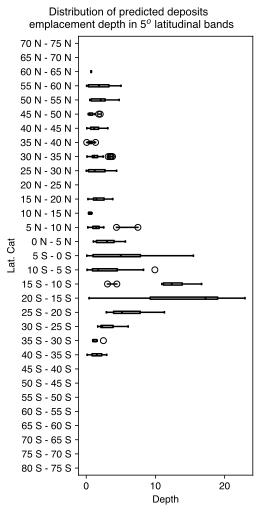

In [15]:
# Assuming depth_df2 is already defined
# Ensure DataFrame is a deep copy and writable
depth_df2 = depth_df.copy(deep=True)

# Ensure 'depth' column is numeric
depth_df2['depth'] = pd.to_numeric(depth_df2['depth'], errors='coerce')

# Check groupby output (for debugging)
grouped = depth_df2.groupby('Lat. Cat')['depth'].apply(list)

# Convert grouped data to writable format
grouped_writable = {key: np.array(value, copy=True) for key, value in grouped.items()}

# Map each unique category to a numeric position
categories = list(grouped_writable.keys())
positions = list(range(len(categories)))

# Define boxplot properties
props = {'boxes': 'Gray'}
fig, ax = plt.subplots(figsize=(3.5, 7), constrained_layout=True)

# Manually plot each group to ensure writability
for pos, (lat_cat, depths) in zip(positions, grouped_writable.items()):
    ax.boxplot(
        [depths], 
        positions=[pos], 
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor='LightGrey', color='Black', linestyle='-', linewidth=1.5),
        medianprops=dict(color='Black', linestyle='-', linewidth=2),
        flierprops=dict(linestyle='-', linewidth=1.5),
        whiskerprops=dict(linestyle='-', linewidth=1.5),
        capprops=dict(linestyle='-', linewidth=1.5)
    )

# Customizing the plot
ax.set_yticks(positions)
ax.set_yticklabels(categories)
ax.grid(False)
plt.title('')
plt.suptitle('Distribution of predicted deposits \n emplacement depth in 5$^{o}$ latitudinal bands', fontsize=11)
plt.xlabel('Depth')
plt.ylabel('Lat. Cat')
plt.show()


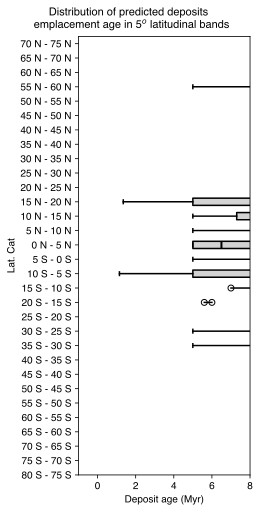

In [16]:
depage = []
for k in range(len(depVars)):
    depage.append(depVars[k].time.values[-1])
age_df = pd.DataFrame()
age_df['age'] = depage
age_df['lat'] = SAlat

lbins = np.arange(-80,80,5).tolist()
llabels = []
for x in range(1, len(lbins)):
    if lbins[x]<=0:
        llabels.append('{} S - {} S'.format(-lbins[x-1],-lbins[x]))
    else:
        llabels.append('{} N - {} N'.format(lbins[x-1],lbins[x]))
lbinned = pd.cut(depth_df['lat'], bins=lbins, labels=llabels)
age_df['Lat. Cat'] = lbinned
age_df['Lat. Cat'] = age_df['Lat. Cat'].astype(dtype="category")
llabels = list(age_df['Lat. Cat'].cat.categories)

props = {'boxes': 'Gray'}
fig, ax = plt.subplots(figsize=(3.5,7),constrained_layout = True)
age_df.boxplot(column=['age'], by='Lat. Cat', 
                color=props, patch_artist=True,
                ax=ax, vert=False, grid=False,
                boxprops=dict(facecolor='LightGrey',color='Black',linestyle='-', linewidth=1.5),
                medianprops=dict(color='Black',linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
               )
plt.title('')
plt.suptitle('Distribution of predicted deposits \n emplacement age in 5$^{o}$ latitudinal bands',fontsize=11)
ax.set_title('')
ax.set_xlabel('Deposit age (Myr)')
plt.xlim(-1, 8)
plt.ylim(1)
plt.show()
# plt.savefig('distAgeHim.pdf',transparent=True)

In [17]:
def plotExhumation(depLocNb):
    
    tmp_df = depVars[depLocNb].copy()
    if len(tmp_df)>3:
        f1 = interp1d(tmp_df['time'], tmp_df['exhrate'],kind='cubic')
        new_index = np.arange(tmp_df['time'][0],tmp_df['time'][len(tmp_df)-1]+0.5,0.5)
        tmp_df2 = pd.DataFrame()
        tmp_df2['time'] = new_index
        tmp_df2['exhrate'] = f1(new_index)
    else:
        tmp_df2 = pd.DataFrame()
        tmp_df2['time'] = tmp_df['time'].values
        tmp_df2['exhrate'] = tmp_df['exhrate'].values

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,2.5),constrained_layout = True) #,gridspec_kw={'width_ratios': [1.5, 1]})

    # Left figure
    colors = tmp_df.exhrate.values
    tmp_df2.plot(x="time", y="exhrate", ax=ax1, 
            kind="line", lw=1.5, c='black',zorder=2,legend=False)
    tmp_df.plot.scatter(x="time", y="exhrate", ax=ax1, marker='o',
                       s=35, c = colors, cmap='viridis',colorbar=False,
                        edgecolors='black',zorder=3)
    ax1.set_xlabel('Deposit age (Myr)')
    ax1.set_ylabel('Exhumation rate \n (km/Myr)')
    ax1.grid(axis='y',zorder=0,alpha=0.3)
    # Right figure
    tmp_df2.boxplot(column=['exhrate'], return_type='axes',
                    patch_artist=True,
                    ax=ax2, vert=False, grid=False,
                    boxprops=dict(facecolor='LightGrey',color='Black',linestyle='-', linewidth=1.5),
                    medianprops=dict(color='Black',linestyle='-', linewidth=2),
                    flierprops=dict(linestyle='-', linewidth=1.5),
                    whiskerprops=dict(linestyle='-', linewidth=1.5),
                    capprops=dict(linestyle='-', linewidth=1.5),
                   )
    ax2.set_title('')

    legend = ('Predicted depth '+str(np.round(-depVars[depLocNb].erodep.values[0]/1000.,3))+
              ' km \n' + 'Mean exhumation rate '+str(np.round(tmp_df2.exhrate.mean(),3))+' km/Myr \n'+
              'Erosion rate (dataset) '+str(np.round(filter2['Erosion rate (km/My) '].values[depLocNb],3))+' km/Myr '
             )

    ax2.text(0.99, 0.95, legend, 
             size=10, color='black',horizontalalignment='right',
             verticalalignment='top',
             transform = ax.transAxes)

    y_axis = ax2.axes.get_yaxis()
    y_axis.set_visible(False)
    ax2.set_xlabel('Exhumation rate (km/Myr)')
    plt.suptitle('Current longitude:'+str(np.round(filter2['Long.'].values[depLocNb],2))+
                 ' latitude:'+str(np.round(filter2['Lat.'].values[depLocNb],2)),
                 fontsize=11
                )
    plt.show()

In [18]:
def plotClimate(depLocNb):
    
    tmp_df = depVars[depLocNb].copy()
    if len(tmp_df)>3:
        f1 = interp1d(tmp_df['time'], tmp_df['rain'],kind='cubic')
        new_index = np.arange(tmp_df['time'][0],tmp_df['time'][len(tmp_df)-1]+0.5,0.5)
        tmp_df3 = pd.DataFrame()
        tmp_df3['time'] = new_index
        tmp_df3['rain'] = f1(new_index)
    else:
        tmp_df3 = pd.DataFrame()
        tmp_df3['time'] = tmp_df['time'].values
        tmp_df3['rain'] = tmp_df['rain'].values

    fig, (ax3, ax4) = plt.subplots(1, 2,figsize=(8,2.5),constrained_layout = True) #,gridspec_kw={'width_ratios': [1.5, 1]})

    # Left figure
    colors = tmp_df.exhrate.values
    tmp_df3.plot(x="time", y="rain", ax=ax3, 
            kind="line", lw=1.5, c='black',zorder=2,legend=False)
    tmp_df.plot.scatter(x="time", y="rain", ax=ax3, marker='o',
                       s=35, c = colors, cmap='Blues',colorbar=False,
                        edgecolors='black',zorder=3)
    ax3.set_xlabel('Deposit age (Myr)')
    ax3.set_ylabel('Average precipitation \n (m/yr)')
    ax3.grid(axis='y',zorder=0,alpha=0.3)
    # Right figure
    tmp_df3.boxplot(column=['rain'], return_type='axes',
                    patch_artist=True,
                    ax=ax4, vert=False, grid=False,
                    boxprops=dict(facecolor='LightGrey',color='Black',linestyle='-', linewidth=1.5),
                    medianprops=dict(color='Black',linestyle='-', linewidth=2),
                    flierprops=dict(linestyle='-', linewidth=1.5),
                    whiskerprops=dict(linestyle='-', linewidth=1.5),
                    capprops=dict(linestyle='-', linewidth=1.5),
                   )
    ax4.set_title('')

    legend = ('Predicted average rainfall '+str(np.round(-depVars[depLocNb].erodep.values[0]/1000.,3))+
              ' m/yr \n' + 'Modern rainfall (dataset) '+str(np.round(filter2['Modern MAP (mm)'].values[depLocNb]/1000.,3))+' m/yr '
             )

    ax4.text(0.99, 0.95, legend, 
             size=10, color='black',horizontalalignment='right',
             verticalalignment='top',
             transform = ax4.transAxes)

    y_axis = ax4.axes.get_yaxis()
    y_axis.set_visible(False)
    ax4.set_xlabel('Average precipitation (m/yr)')
    plt.suptitle('Current longitude:'+str(np.round(filter2['Long.'].values[depLocNb],2))+
                 ' latitude:'+str(np.round(filter2['Lat.'].values[depLocNb],2)),
                 fontsize=11
                )
plt.show()

In [19]:
def predictedExhumRate(depLocNb):
    
    tmp_df = depVars[depLocNb].copy()
    tmp_df = tmp_df.iloc[:-1]
    exhon = tmp_df[tmp_df['exhrate'] < 0.]  
    exrate = np.mean(exhon.exhrate.values[:-1])
    
    return -np.round(exrate,3)

exhum = []
for k in range(len(SAlat)):
    exhum.append(predictedExhumRate(k))
    
exhum_df = pd.DataFrame()
exhum_df['exhum'] = meanero #exhum
exhum_df['exhumPaper'] = 2./np.asarray(depage)
exhum_df['lat'] = SAlat
exhum_df['depth'] = emplacedepth.copy() #depth
exhum_df['depthPred'] = emplacedepth.copy() #exhum*np.asarray(depage)
exhum_df['age'] = depage

lbins = np.arange(-90,91,15).tolist()
llabels = []
for x in range(1, len(lbins)):
    if lbins[x]<=0:
        llabels.append('{} S - {} S'.format(-lbins[x-1],-lbins[x]))
    else:
        llabels.append('{} N - {} N'.format(lbins[x-1],lbins[x]))
lbinned = pd.cut(depth_df['lat'], bins=lbins, labels=llabels)
exhum_df['Lat. Cat'] = lbinned
exhum_df['Lat. Cat'] = exhum_df['Lat. Cat'].astype(dtype="category")
llabels = list(exhum_df['Lat. Cat'].cat.categories)

In [20]:
# exhum_df.to_csv('model_all_data.csv', index=False)

In [21]:
newexhum = exhum_df[exhum_df.exhum.notna()]
# newexhum = newexhum[newexhum.depthPred<10.]
# newexhum = newexhum[newexhum.depthPred>0.1]

In [22]:
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65]
labels = []
for x in range(1, len(bins)):
    labels.append('{} Ma - {} Ma'.format(bins[x-1],bins[x]))
binned = pd.cut(newexhum['age'], bins=bins, labels=labels)
newexhum['Ages Cat'] = binned
newexhum['Ages Cat'] = newexhum['Ages Cat'].astype(dtype="category")
agelabels = list(newexhum['Ages Cat'].cat.categories)

In [23]:
newexhum.depthPred.max()

3.102543840581189

In [24]:
newexhum.to_csv('model_all_data2.csv', index=False)

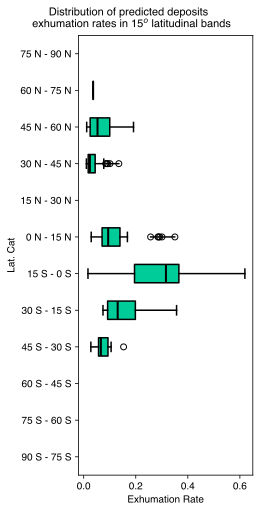

In [25]:
# Create a new DataFrame with writable data
grouped_data = newexhum.groupby('Lat. Cat')['exhum'].apply(list)

# Convert grouped data to a list of lists
data_lists = [grouped_data[key] for key in grouped_data.keys()]

# Define boxplot properties
props = {'boxes': 'Gray'}
fig, ax = plt.subplots(figsize=(3.5, 7), constrained_layout=True)

# Manually plot each group to ensure writability
ax.boxplot(data_lists, vert=False,
           patch_artist=True,
           boxprops=dict(facecolor='#00cc99', color='Black', linestyle='-', linewidth=1.5),
           medianprops=dict(color='Black', linestyle='-', linewidth=2),
           flierprops=dict(linestyle='-', linewidth=1.5),
           whiskerprops=dict(linestyle='-', linewidth=1.5),
           capprops=dict(linestyle='-', linewidth=1.5))

# Customizing the plot
ax.set_yticks(np.arange(len(grouped_data)) + 1)
ax.set_yticklabels(grouped_data.keys())
ax.grid(False)
plt.title('')
plt.suptitle('Distribution of predicted deposits \n exhumation rates in 15$^{o}$ latitudinal bands', fontsize=11)
plt.xlabel('Exhumation Rate')
plt.ylabel('Lat. Cat')
plt.show()


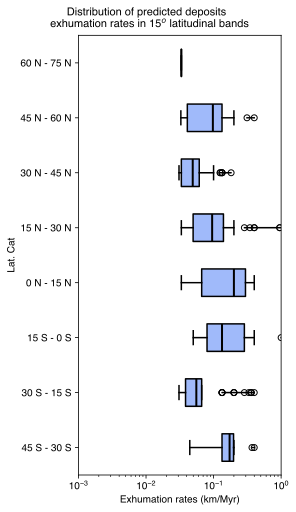

In [26]:
# #00cc99 green
# #A0BAFA blue
props = {'boxes': 'Gray'}
fig, ax = plt.subplots(figsize=(4,7),constrained_layout = True)
newexhum.boxplot(column=['exhumPaper'], by='Lat. Cat', 
                color=props, patch_artist=True,
                ax=ax, vert=False, grid=False,
                boxprops=dict(facecolor='#A0BAFA',color='Black',linestyle='-', linewidth=1.5),
                medianprops=dict(color='Black',linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
               )

plt.title('')
plt.suptitle('Distribution of predicted deposits \n exhumation rates in 15$^{o}$ latitudinal bands',
             fontsize=11)
ax.set_title('')
ax.set_xlabel('Exhumation rates (km/Myr)')
ax.set_xscale('log')
plt.xlim(1.e-3, 1)
plt.ylim(3.5,11.5) #,5.5)
# plt.show()
plt.savefig('distExhumAll2.pdf',transparent=True)

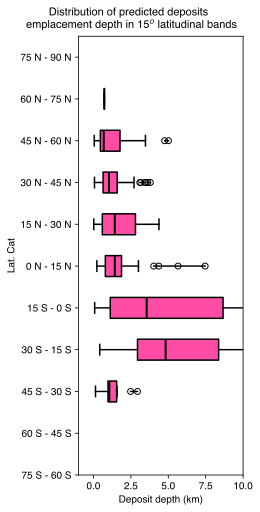

In [27]:
# Make a copy of the DataFrame to ensure writability
newexhum_copy = newexhum.copy()

# Convert the 'depthPred' column to a writable format
newexhum_copy['depthPred'] = newexhum_copy['depthPred'].astype(float)


props = {'boxes': 'Gray'}
fig, ax = plt.subplots(figsize=(3.5,7),constrained_layout = True)
newexhum_copy.boxplot(column=['depthPred'], by='Lat. Cat', 
                color=props, patch_artist=True,
                ax=ax, vert=False, grid=False,
                boxprops=dict(facecolor='#ff4da6',color='Black',linestyle='-', linewidth=1.5),
                medianprops=dict(color='Black',linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
               )
plt.title('')
plt.suptitle('Distribution of predicted deposits \n emplacement depth in 15$^{o}$ latitudinal bands',fontsize=11)
ax.set_title('')
ax.set_xlabel('Deposit depth (km)')
plt.xlim(-1, 10)
plt.ylim(2) #1,6.5)
plt.show()
# plt.ylim(3.5,11.5)
# plt.savefig('distDepthAll.pdf',transparent=True)

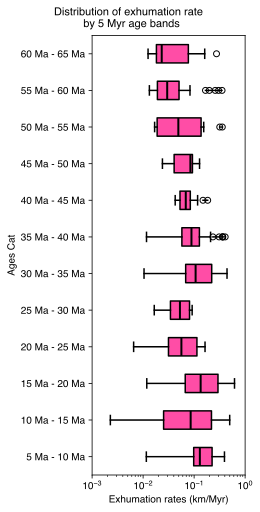

In [44]:
colors = np.arange(0,15)
cm = plt.cm.get_cmap('rainbow_r')
colors_cm = [cm((c-colors.min())/(colors.max()-colors.min())) for c in colors]

# Make a copy of the DataFrame to ensure writability
newexhum_copy1 = newexhum.copy()

# Convert the 'depthPred' column to a writable format
newexhum_copy1['exhum'] = newexhum_copy['exhum'].astype(float)



props = {'boxes': 'Gray'}
fig, ax = plt.subplots(figsize=(3.5,7),constrained_layout = True)
newexhum_copy1.boxplot(column=['exhum'], by='Ages Cat', 
                color=props, patch_artist=True,
                ax=ax, vert=False, grid=False,
                boxprops=dict(facecolor='#ff4da6',color='Black',linestyle='-', linewidth=1.5),
                medianprops=dict(color='Black',linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
               )



        
plt.title('')
plt.suptitle('Distribution of exhumation rate \n by 5 Myr age bands',
             fontsize=11)
ax.set_title('')
ax.set_xlabel('Exhumation rates (km/Myr)')
ax.set_xscale('log')
plt.xlim(1.e-3, 1)
plt.ylim(1.5)
plt.show()
# plt.savefig('ageExhumAll.pdf',transparent=True)

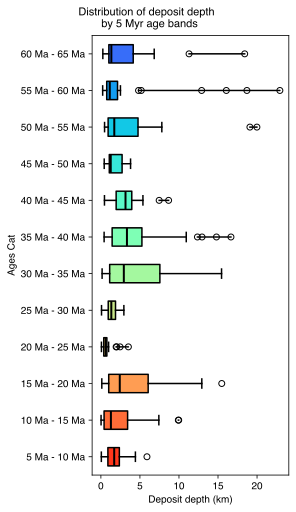

In [31]:
props = {'boxes': 'Gray'}
fig, ax = plt.subplots(figsize=(4,7),constrained_layout = True)
bp_dict = newexhum_copy.boxplot(column=['depthPred'], by='Ages Cat', 
                color=props, patch_artist=True, return_type='both',
                ax=ax, vert=False, grid=False,
                boxprops=dict(facecolor='#eb3474',color='Black',linestyle='-', linewidth=1.5),
                medianprops=dict(color='Black',linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
               )
for row_key, (ax, row) in bp_dict.items():
    ax.set_xlabel('')
    for i, box in enumerate(row['boxes']):
        box.set_facecolor(colors_cm[i])

        
plt.title('')
plt.suptitle('Distribution of deposit depth \n by 5 Myr age bands',
             fontsize=11)
ax.set_title('')
ax.set_xlabel('Deposit depth (km)')
# ax.set_xscale('log')
# plt.xlim(1.e-3, 1)
plt.ylim(1.5)
plt.show()
# plt.savefig('depthAgeAll.pdf',transparent=True)

(2.0, 12.5)

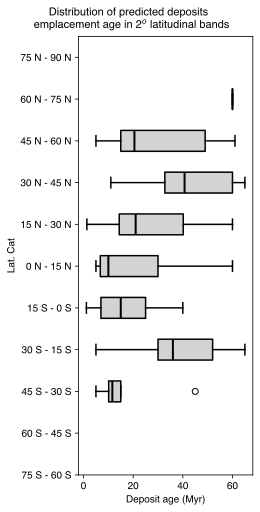

In [32]:
props = {'boxes': 'Gray'}
fig, ax = plt.subplots(figsize=(3.5,7),constrained_layout = True)
newexhum.boxplot(column=['age'], by='Lat. Cat', 
                color=props, patch_artist=True,
                ax=ax, vert=False, grid=False,
                boxprops=dict(facecolor='LightGrey',color='Black',linestyle='-', linewidth=1.5),
                medianprops=dict(color='Black',linestyle='-', linewidth=2),
                flierprops=dict(linestyle='-', linewidth=1.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
               )
plt.title('')
plt.suptitle('Distribution of predicted deposits \n emplacement age in 2$^{o}$ latitudinal bands',fontsize=11)
ax.set_title('')
ax.set_xlabel('Deposit age (Myr)')
# plt.xlim(-1, 8)
plt.ylim(2) #,6.5)
# plt.show()
# plt.savefig('distAgeAll.pdf',transparent=True)

In [33]:
newexhum['lon'] = data_df['Long.'].copy()
newexhum['erate'] = data_df['Ind. depth e-rate (km/My)'].copy()

In [34]:
newexhum.to_csv('model_all_data.csv', index=False)

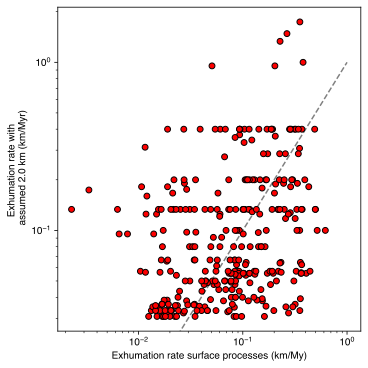

In [35]:
fig, ax = plt.subplots(1, 1,figsize=(5,5),constrained_layout = True) 
newexhum.plot.scatter(x='exhum', y='exhumPaper', c='red', ax=ax, s=35, edgecolors='black')
ax.plot([0,1],[0,1],zorder=0,lw=1.5,ls='--',c='gray')
ax.set_xlabel('Exhumation rate surface processes (km/My)')
ax.set_ylabel('Exhumation rate with \n assumed 2.0 km (km/Myr)')
ax.set_xscale('log')
ax.set_yscale('log')
# plt.xlim(1.e-2, 1)
# plt.ylim(1.e-2, 1)
plt.show()

In [36]:
newex = newexhum[newexhum.erate > 0]
newex

,exhum,exhumPaper,lat,depth,depthPred,age,Lat. Cat,Ages Cat,lon,erate
0,0.204994,0.363636,-27.3710,2.152437,2.152437,5.50,30 S - 15 S,5 Ma - 10 Ma,-66.280,0.363640
3,0.146399,0.200000,-27.3300,2.195988,2.195988,10.00,30 S - 15 S,5 Ma - 10 Ma,-66.609,0.337070
19,0.06272,0.090909,39.1440,0.627196,0.627196,22.00,30 N - 45 N,20 Ma - 25 Ma,46.138,0.068182
22,0.154264,0.038095,55.0030,5.013586,5.013586,52.50,45 N - 60 N,50 Ma - 55 Ma,-126.230,0.022857
23,0.084487,0.040000,53.8040,1.689733,1.689733,50.00,45 N - 60 N,45 Ma - 50 Ma,-127.440,0.040404
27,0.153456,0.039216,54.9460,4.757132,4.757132,51.00,45 N - 60 N,50 Ma - 55 Ma,-126.160,0.023529
29,0.099297,0.040000,55.1940,3.475385,3.475385,50.00,45 N - 60 N,45 Ma - 50 Ma,-126.320,0.024000
58,0.102516,0.055556,-21.0000,4.203168,4.203168,36.00,30 S - 15 S,35 Ma - 40 Ma,-68.800,0.041667
70,0.077235,0.055556,31.0830,3.166641,3.166641,36.00,30 N - 45 N,35 Ma - 40 Ma,97.867,0.063889
78,0.084538,0.054795,31.0000,3.508346,3.508346,36.50,30 N - 45 N,35 Ma - 40 Ma,97.950,0.063014


In [37]:
newex.to_csv('model_all_data.csv', index=False)

In [38]:
exhsim = []
exhsimmean = []
for p in range(len(newex)):
    for k in range(len(depVars)):
        lonDep = allTrail[k][0][0]
        latDep = allTrail[k][1][0]
        if np.abs(latDep - newex.iloc[p]['lat']) < 0.01 and np.abs(lonDep - newex.iloc[p]['lon']) < 0.01:
            exhsim.append(depVars[k].exhrate.max())
            val = depVars[k].exhrate.values
            ids = np.where(val>0)
            exhsimmean.append(np.median(val[ids]))
            
newex['erateMax'] = exhsim
newex['erateMean'] = exhsimmean

In [39]:
newex.to_csv('model_data.csv', index=False)

In [40]:
comb_exh = newex[['erate','erateMax','erateMean','exhumPaper']] #.sort_values('Ind. depth e-rate (km/My)')
comb_exh

,erate,erateMax,erateMean,exhumPaper
0,0.363640,0.304955,0.119817,0.363636
3,0.337070,0.165343,0.149794,0.200000
19,0.068182,0.118515,0.062720,0.090909
22,0.022857,0.383537,0.102022,0.038095
23,0.040404,0.119050,0.078420,0.040000
27,0.023529,0.323237,0.103226,0.039216
29,0.024000,0.229805,0.073926,0.040000
58,0.041667,0.268700,0.093192,0.055556
70,0.063889,0.217396,0.038457,0.055556
78,0.063014,0.209396,0.076651,0.054795


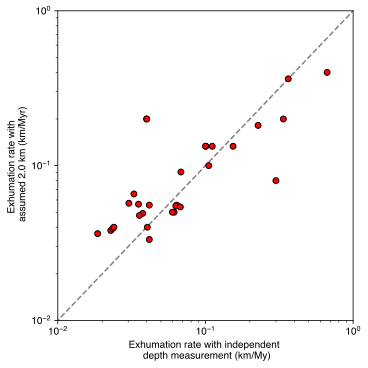

In [41]:
fig, ax = plt.subplots(1, 1,figsize=(5,5),constrained_layout = True) 
comb_exh.plot.scatter(x='erate', y='exhumPaper', c='red', ax=ax, s=35, edgecolors='black')
ax.plot([0,1],[0,1],zorder=0,lw=1.5,ls='--',c='gray')
ax.set_xlabel('Exhumation rate with independent \n depth measurement (km/My)')
ax.set_ylabel('Exhumation rate with \n assumed 2.0 km (km/Myr)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(1.e-2, 1)
plt.ylim(1.e-2, 1)
plt.show()

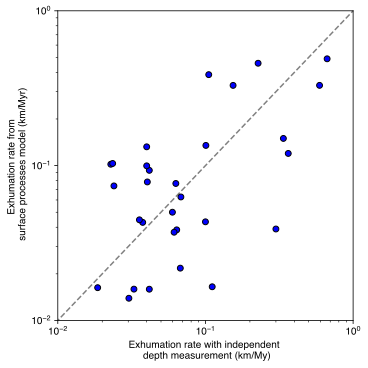

In [42]:
fig, ax = plt.subplots(1, 1,figsize=(5,5),constrained_layout = True) 
comb_exh.plot.scatter(x='erate', y='erateMean', c='blue', ax=ax, s=35, edgecolors='black')
ax.plot([0,1],[0,1],zorder=0,lw=1.5,ls='--',c='gray')
ax.set_xlabel('Exhumation rate with independent \n depth measurement (km/My)')
ax.set_ylabel('Exhumation rate from \n surface processes model (km/Myr)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(1.e-2, 1)
plt.ylim(1.e-2, 1)
plt.show()

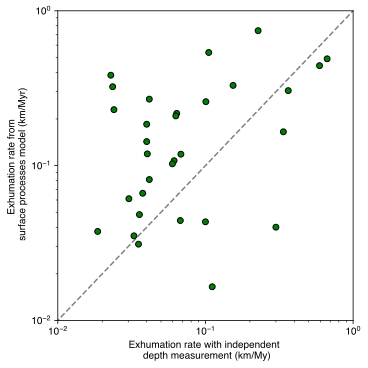

In [43]:
fig, ax = plt.subplots(1, 1,figsize=(5,5),constrained_layout = True) 
comb_exh.plot.scatter(x='erate', y='erateMax', c='green', ax=ax, s=35, edgecolors='black')
ax.plot([0,1],[0,1],zorder=0,lw=1.5,ls='--',c='gray')
ax.set_xlabel('Exhumation rate with independent \n depth measurement (km/My)')
ax.set_ylabel('Exhumation rate from \n surface processes model (km/Myr)')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlim(1.e-2, 1)
plt.ylim(1.e-2, 1)
plt.show()